cuda


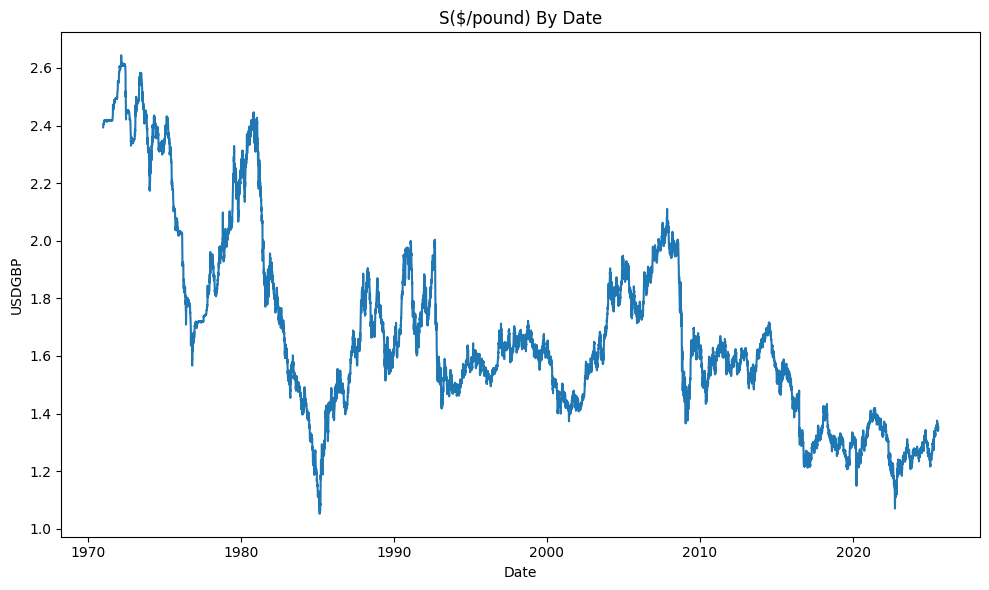

In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
fred_api_key = os.getenv(".env")
import fredapi as fr
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error,r2_score


device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


fred = fr.Fred(fred_api_key)

"""The USD/GBP Spot rate"""

usdgbp = fred.get_series("DEXUSUK")
usdgbp.name = "USDGBP"

df = pd.concat([usdgbp],axis=1).dropna()
df = df.reset_index()
df['Date'] = df['index']
df.drop('index',axis=1,inplace=True)

plt.figure(figsize=(10,6))
sns.lineplot(x='Date',y='USDGBP',data=df)
plt.title("S($/pound) By Date")
plt.savefig("images/spotrate.png")
plt.tight_layout()
plt.show()






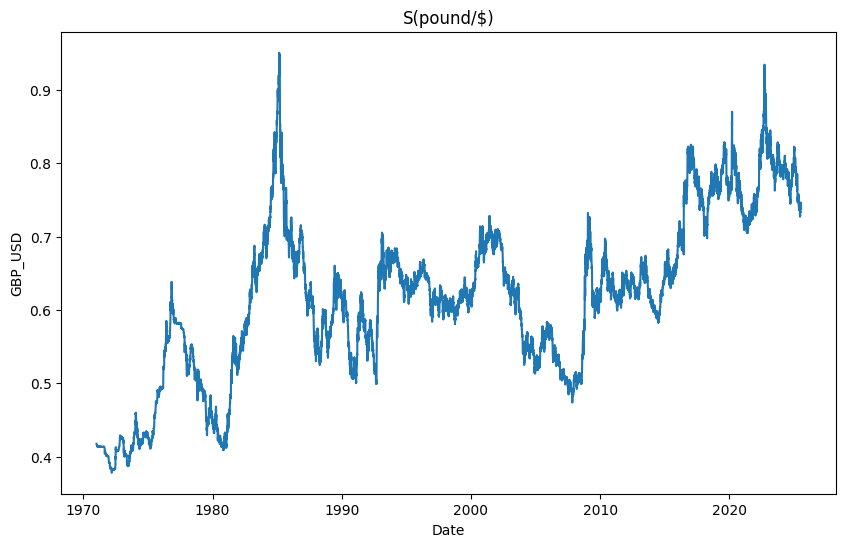

In [2]:
""" Example of S(pound/USD)"""

df1 = df.copy()
df1['GBP_USD'] = 1 / df['USDGBP']

plt.figure(figsize=(10,6))
sns.lineplot(x=df1['Date'],y=df1['GBP_USD'])
plt.title("S(pound/$)")
plt.savefig("images/sportrate_GBPUSD")
plt.show()




In [3]:



GBP_USD = 1  / df['USDGBP']

USD_GBP = 1 / GBP_USD

A = np.array([[USD_GBP,GBP_USD],[GBP_USD,USD_GBP]])

print(f'1:1 Parity of of Exchange Rates: {A.T}')



1:1 Parity of of Exchange Rates: [[[2.3938     0.41774584]
  [0.41774584 2.3938    ]]

 [[2.3949     0.41755397]
  [0.41755397 2.3949    ]]

 [[2.3967     0.41724037]
  [0.41724037 2.3967    ]]

 ...

 [[1.3566     0.73713696]
  [0.73713696 1.3566    ]]

 [[1.3524     0.73942621]
  [0.73942621 1.3524    ]]

 [[1.3429     0.74465709]
  [0.74465709 1.3429    ]]]


In [4]:
df1 = df.copy()


df1.dropna(inplace=True)

df_train = df1.iloc[:,0:1].values



train_size = int(len(df_train) * .90)


train_data = df_train[:train_size]
test_data = df_train[train_size:]


scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)



def slider(dataframe,seq_length):
    X,y = [],[]
    for i in range(len(dataframe) - seq_length):
        Xi = dataframe[i:(i+seq_length)]
        yi = dataframe[(i+seq_length)]
        X.append(Xi)
        y.append(yi)
        
    return np.array(X),np.array(y)

seq_length = 4

X_train,y_train = slider(train_scaled,seq_length)
X_test,y_test = slider(test_scaled,seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()




class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        h0 = torch.zeros(1, X.size(0), self.hidden_size)
        c0 = torch.zeros(1, X.size(0), self.hidden_size)
        out, _ = self.lstm(X, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out






In [5]:




lstm_model = LSTM(input_size=1,hidden_size=128,num_layers=1,output_size=1)
epochs = 500
learning_rate = 0.001



lstm_optimizer = torch.optim.Adam(params=lstm_model.parameters(),lr=learning_rate)
loss_fn = nn.MSELoss()

In [6]:


for epoch in range(epochs):
    y_pred = lstm_model(X_train)
    loss = loss_fn(y_pred.float(),y_train)
    lstm_optimizer.zero_grad()
    loss.backward()
    lstm_optimizer.step()
    if epoch % 1 != 0:
        continue
    lstm_model.eval()
    with torch.no_grad():
        y_pred = lstm_model(X_train)
        train_rsme = np.sqrt(loss_fn(y_pred,y_train))
        y_pred_test =  lstm_model(X_test)
        test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))
        print(f'Epoch: {epoch}; train_RSEM: {train_rsme:.4}; Test RSME: {test_rsme:.4}')
        




C:\Users\katsa\AppData\Local\Temp\ipykernel_17908\1282510991.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rsme = np.sqrt(loss_fn(y_pred,y_train))
C:\Users\katsa\AppData\Local\Temp\ipykernel_17908\1282510991.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))


Epoch: 0; train_RSEM: 0.4; Test RSME: 0.086
Epoch: 1; train_RSEM: 0.3814; Test RSME: 0.0692
Epoch: 2; train_RSEM: 0.3629; Test RSME: 0.05415
Epoch: 3; train_RSEM: 0.3444; Test RSME: 0.04288
Epoch: 4; train_RSEM: 0.3257; Test RSME: 0.03931
Epoch: 5; train_RSEM: 0.307; Test RSME: 0.04596
Epoch: 6; train_RSEM: 0.2881; Test RSME: 0.06025
Epoch: 7; train_RSEM: 0.2691; Test RSME: 0.07882
Epoch: 8; train_RSEM: 0.2503; Test RSME: 0.1
Epoch: 9; train_RSEM: 0.2319; Test RSME: 0.1232
Epoch: 10; train_RSEM: 0.2145; Test RSME: 0.148
Epoch: 11; train_RSEM: 0.1989; Test RSME: 0.1744
Epoch: 12; train_RSEM: 0.1863; Test RSME: 0.202
Epoch: 13; train_RSEM: 0.1782; Test RSME: 0.2305
Epoch: 14; train_RSEM: 0.1756; Test RSME: 0.2589
Epoch: 15; train_RSEM: 0.1785; Test RSME: 0.2858
Epoch: 16; train_RSEM: 0.1851; Test RSME: 0.3089
Epoch: 17; train_RSEM: 0.1922; Test RSME: 0.326
Epoch: 18; train_RSEM: 0.1971; Test RSME: 0.3359
Epoch: 19; train_RSEM: 0.1985; Test RSME: 0.3385
Epoch: 20; train_RSEM: 0.1963; Test

Root Mean Squared Error: 0.0072
R2 Score: 96.83%


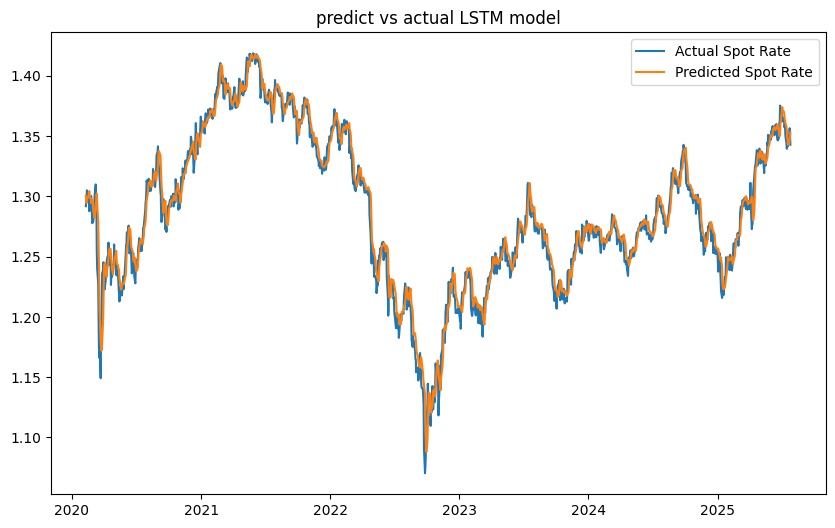

In [8]:

with torch.no_grad():
    pred = lstm_model(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)

rmse = root_mean_squared_error(y_test_np,pred_np)
print(f'Root Mean Squared Error: {rmse:.4f}')
r2 = r2_score(y_test_np,pred_np)
print(f'R2 Score: {r2*100:.2f}%')

test_dates = df1.iloc[train_size + seq_length:]['Date']


lstm_comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Spot Rate": actual_rescaled.flatten(),
    "Predicted Spot Rate": pred_rescaled.flatten()
})



plt.figure(figsize=(10,6))
plt.plot(lstm_comparison_df['Date'],lstm_comparison_df["Actual Spot Rate"],label="Actual Spot Rate")
plt.plot(lstm_comparison_df['Date'],lstm_comparison_df['Predicted Spot Rate'],label="Predicted Spot Rate")
plt.title("predict vs actual LSTM model")
plt.legend()
plt.savefig("images/predicted_vs_actual_SpotRate_lstm.png")
plt.show()


In [9]:
print(np.round(lstm_comparison_df,4).head(20))
print(np.round(lstm_comparison_df,4).tail(20))


            Date  Actual Spot Rate  Predicted Spot Rate
12318 2020-02-10            1.2919               1.3005
12319 2020-02-11            1.2945               1.2971
12320 2020-02-12            1.2978               1.2947
12321 2020-02-13            1.3051               1.2950
12322 2020-02-14            1.3039               1.2978
12323 2020-02-18            1.3017               1.3011
12324 2020-02-19            1.2934               1.3038
12325 2020-02-20            1.2877               1.3044
12326 2020-02-21            1.2966               1.3009
12327 2020-02-24            1.2923               1.2976
12328 2020-02-25            1.3004               1.2944
12329 2020-02-26            1.2921               1.2952
12330 2020-02-27            1.2876               1.2977
12331 2020-02-28            1.2778               1.2962
12332 2020-03-02            1.2791               1.2944
12333 2020-03-03            1.2827               1.2883
12334 2020-03-04            1.2836              